In [2]:
import os
import pandas as pd
from sklearn.metrics import r2_score

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'
# Definir look_back
look_back = 6  

# Cargar el archivo y eliminar filas donde el clúster es NaN
file_path = 'data/data.csv'   # Cambia esta ruta al archivo que has subido
data = pd.read_csv(file_path)
data = data.dropna(subset=['Cluster_Label'])

# Convertir 'year' y 'month_no' a una sola columna de tipo fecha
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month_no'].astype(str))


import os
import pandas as pd
from sklearn.metrics import r2_score

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar un DataFrame para almacenar los valores de R2
r2_df = pd.DataFrame(index=unique_species, columns=unique_clusters)

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular el R2
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Calcular el R2 para los totales mensuales, si hay suficientes datos
            if not monthly_totals.empty:
                r2 = r2_score(monthly_totals['real_values'], monthly_totals['predictions'])
                # Almacenar el R2 en el DataFrame
                r2_df.at[species_name, cluster_label] = r2
            else:
                #print(f'Sin datos suficientes para calcular R2 para especie: {species_name}, clúster: {cluster_label}')
                r2_df.at[species_name, cluster_label] = None
        else:
            #print(f'Archivo no encontrado para especie: {species_name}, clúster: {cluster_label}')
            r2_df.at[species_name, cluster_label] = None

# Guardar el DataFrame de R2 en un archivo CSV
r2_output_path = os.path.join(results_directory, 'r2_scores.csv')
r2_df.to_csv(r2_output_path)

print(f'Tabla de R2 guardada en: {r2_output_path}')

/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Tabla de R2 guardada en: resultados_moe/r2_scores.csv


/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


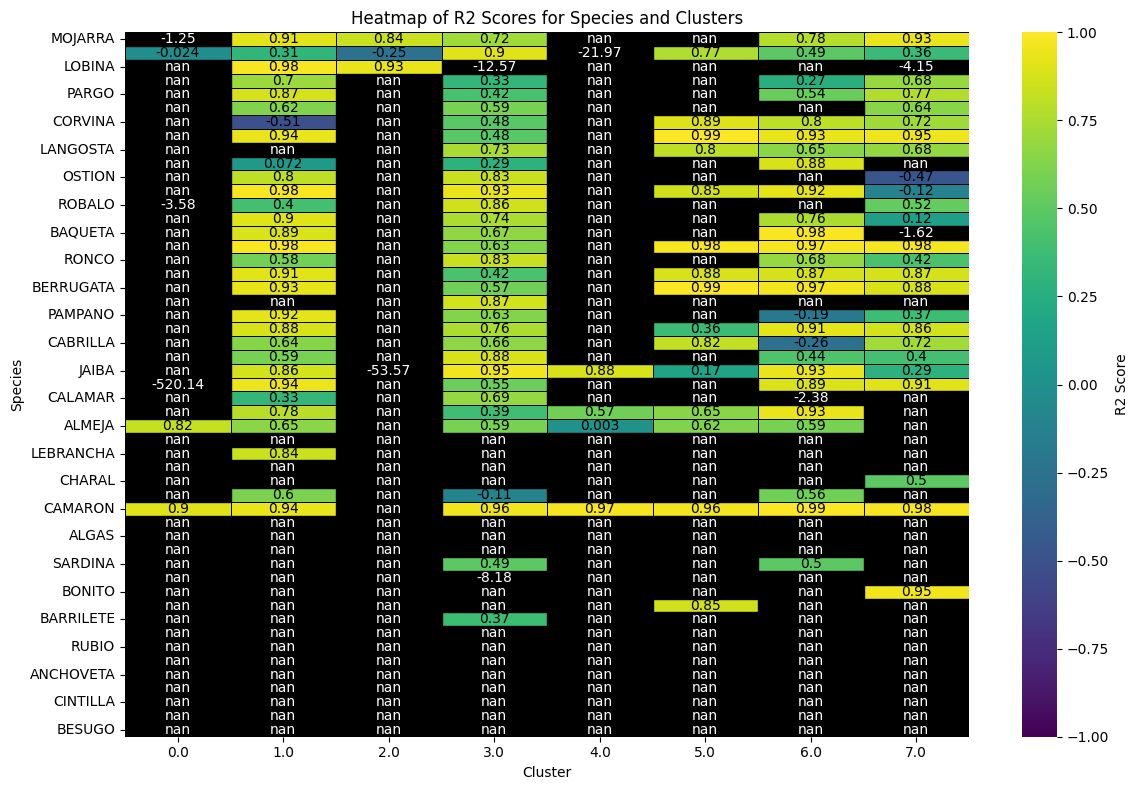

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Definir el orden deseado de las columnas
column_order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']

# Asegurar que las columnas estén en formato string y reindexar
r2_df.columns = r2_df.columns.astype(str)
r2_df = r2_df.reindex(columns=column_order)

# Asegurar que el índice también esté en formato string
r2_df.index = r2_df.index.astype(str)

# Reemplazar valores None o NaN con np.nan
r2_df = r2_df.apply(pd.to_numeric, errors='coerce')

# Crear una máscara para los valores fuera del rango [-1, 1]
mask = (r2_df < -1) | (r2_df > 1) | r2_df.isna()

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(r2_df, annot=True, cmap='viridis', cbar_kws={'label': 'R2 Score'}, linewidths=.5, linecolor='black', vmin=-1, vmax=1, mask=mask, annot_kws={"color": "black"})

# Pintar en negro las celdas fuera del rango [-1, 1]
for i in range(r2_df.shape[0]):
    for j in range(r2_df.shape[1]):
        if mask.iloc[i, j]:
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black'))
            heatmap.text(j + 0.5, i + 0.5, '{:.2f}'.format(r2_df.iloc[i, j]), ha='center', va='center', color='white')

# Añadir títulos y etiquetas
plt.title('Heatmap of R2 Scores for Species and Clusters')
plt.xlabel('Cluster')
plt.ylabel('Species')

# Mostrar el mapa de calor
plt.tight_layout()
plt.show()


Sin datos suficientes para calcular r para especie: PARGO, clúster: 0.0
Sin datos suficientes para calcular r para especie: PARGO, clúster: 4.0
Sin datos suficientes para calcular r para especie: LANGOSTA, clúster: 1.0
Sin datos suficientes para calcular r para especie: LENGUADO, clúster: 2.0
Sin datos suficientes para calcular r para especie: ERIZO, clúster: 3.0
Sin datos suficientes para calcular r para especie: SARGAZO, clúster: 3.0


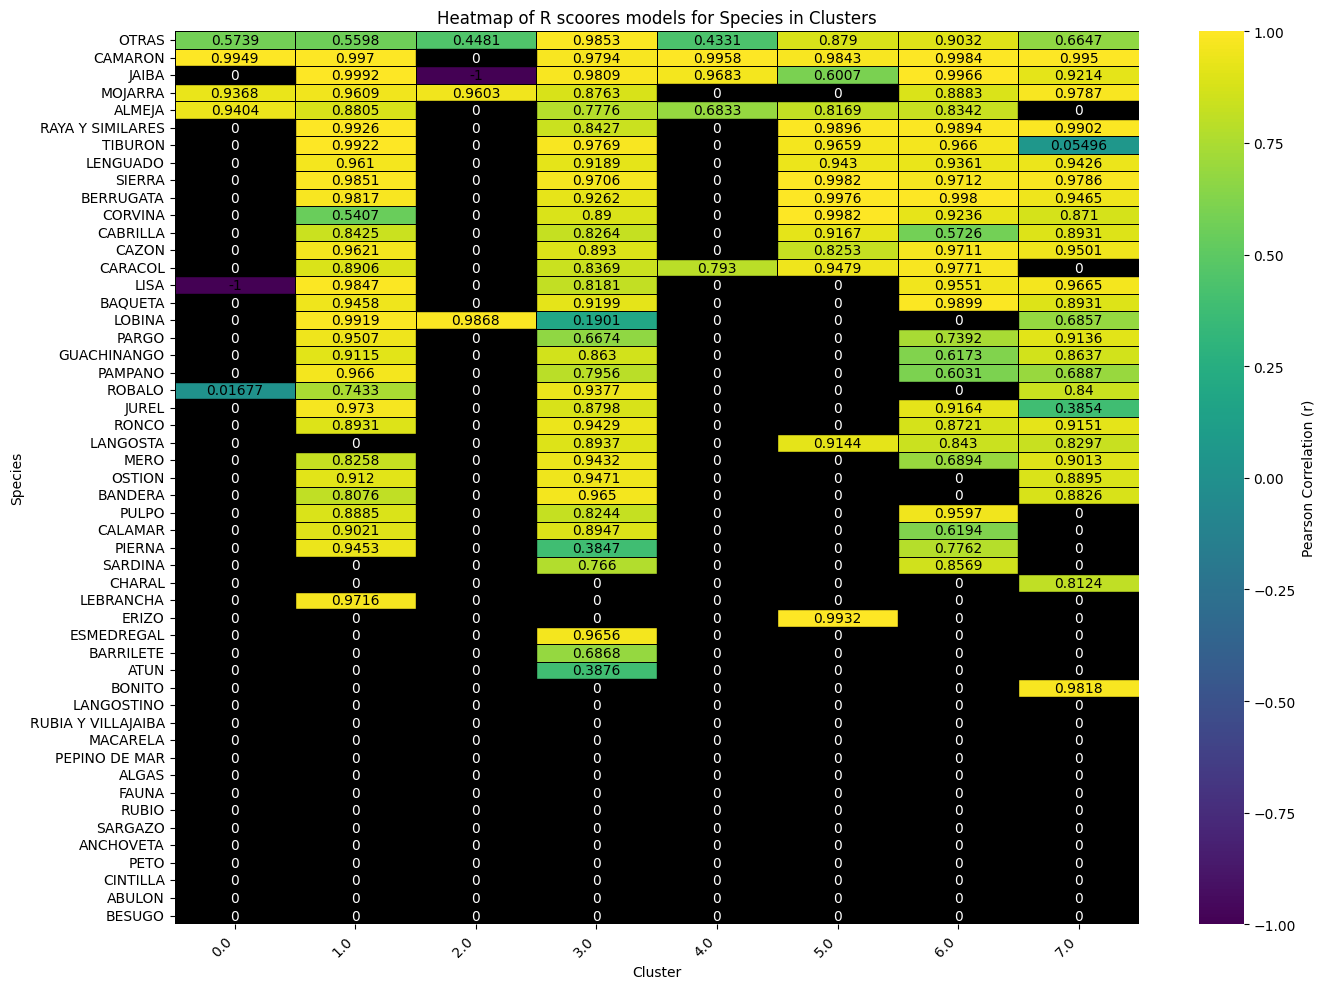

In [4]:
import os
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar un DataFrame para almacenar los valores de r
r_df = pd.DataFrame(index=unique_species, columns=unique_clusters)

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular r
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular el coeficiente de correlación de Pearson (r)
            if len(monthly_totals) >= 2:
                r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                # Almacenar el valor de r en el DataFrame
                r_df.at[species_name, cluster_label] = r
            else:
                print(f'Sin datos suficientes para calcular r para especie: {species_name}, clúster: {cluster_label}')
                r_df.at[species_name, cluster_label] = None
        else:
            #print(f'Archivo no encontrado para especie: {species_name}, clúster: {cluster_label}')
            r_df.at[species_name, cluster_label] = None

# Reemplazar valores None o NaN con np.nan
r_df = r_df.apply(pd.to_numeric, errors='coerce')

# Contar los valores no nulos por fila y ordenar las especies
r_df['non_null_count'] = r_df.notnull().sum(axis=1)
r_df = r_df.sort_values(by='non_null_count', ascending=False).drop(columns=['non_null_count'])

# Definir el orden deseado de las columnas
column_order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']

# Reindexar el DataFrame según el orden de las columnas
r_df.columns = r_df.columns.astype(str)
r_df = r_df.reindex(columns=column_order)
r_df.index = r_df.index.astype(str)

# Crear una máscara para los valores fuera del rango [-1, 1]
mask = (r_df < -1) | (r_df > 1) | r_df.isna()

# Crear el mapa de calor
plt.figure(figsize=(14, 10))  # Aumentar el tamaño de la figura
heatmap = sns.heatmap(r_df, annot=True, cmap='viridis', cbar_kws={'label': 'Pearson Correlation (r)'}, linewidths=.5, linecolor='black', vmin=-1, vmax=1, mask=mask, annot_kws={"color": "black"}, fmt=".4g")

# Pintar en negro las celdas fuera del rango [-1, 1]
for i in range(r_df.shape[0]):
    for j in range(r_df.shape[1]):
        if mask.iloc[i, j]:
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black'))
            heatmap.text(j + 0.5, i + 0.5, '{:.4g}'.format(r_df.iloc[i, j] if not np.isnan(r_df.iloc[i, j]) else 0), ha='center', va='center', color='white')

# Ajustar los ticks de los ejes para mayor claridad
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas de las columnas
plt.yticks(rotation=0)  # Asegurar que las etiquetas de los renglones estén rectas

# Añadir títulos y etiquetas
plt.title('Heatmap of R scoores models for Species in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Species')

# Mostrar el mapa de calor
plt.tight_layout()
plt.show()


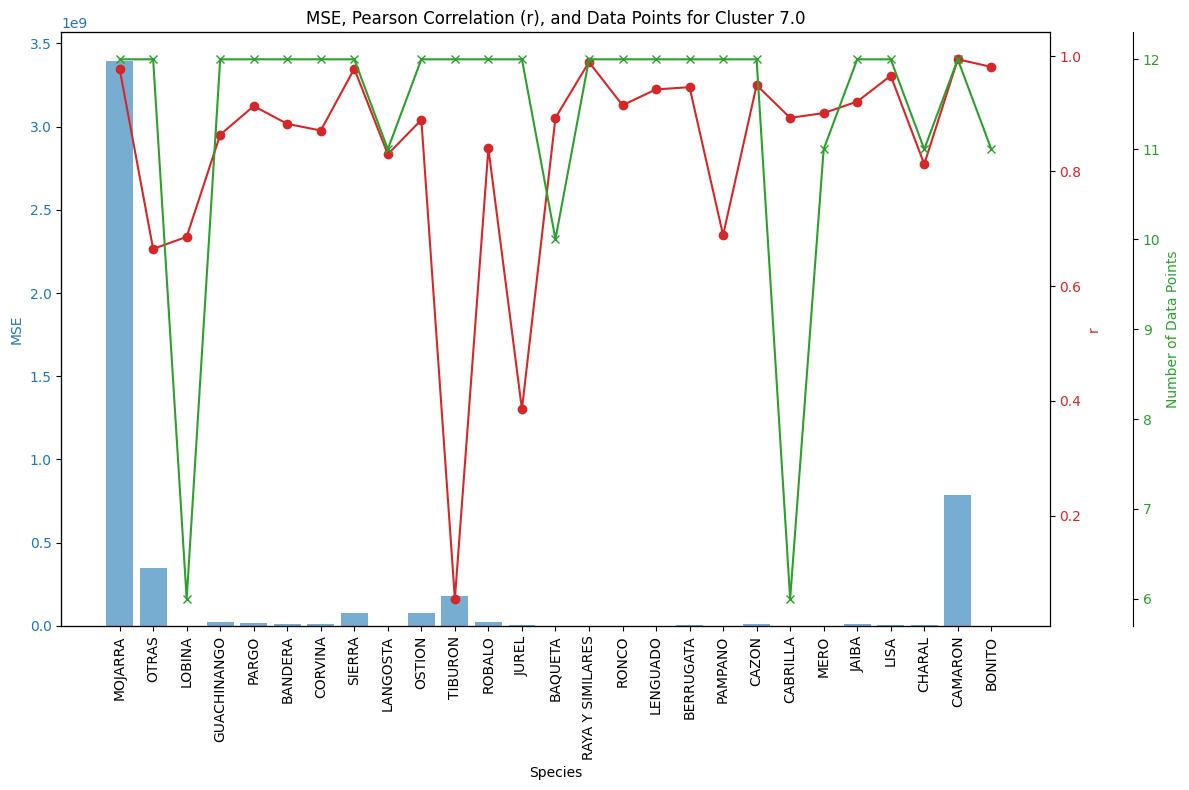

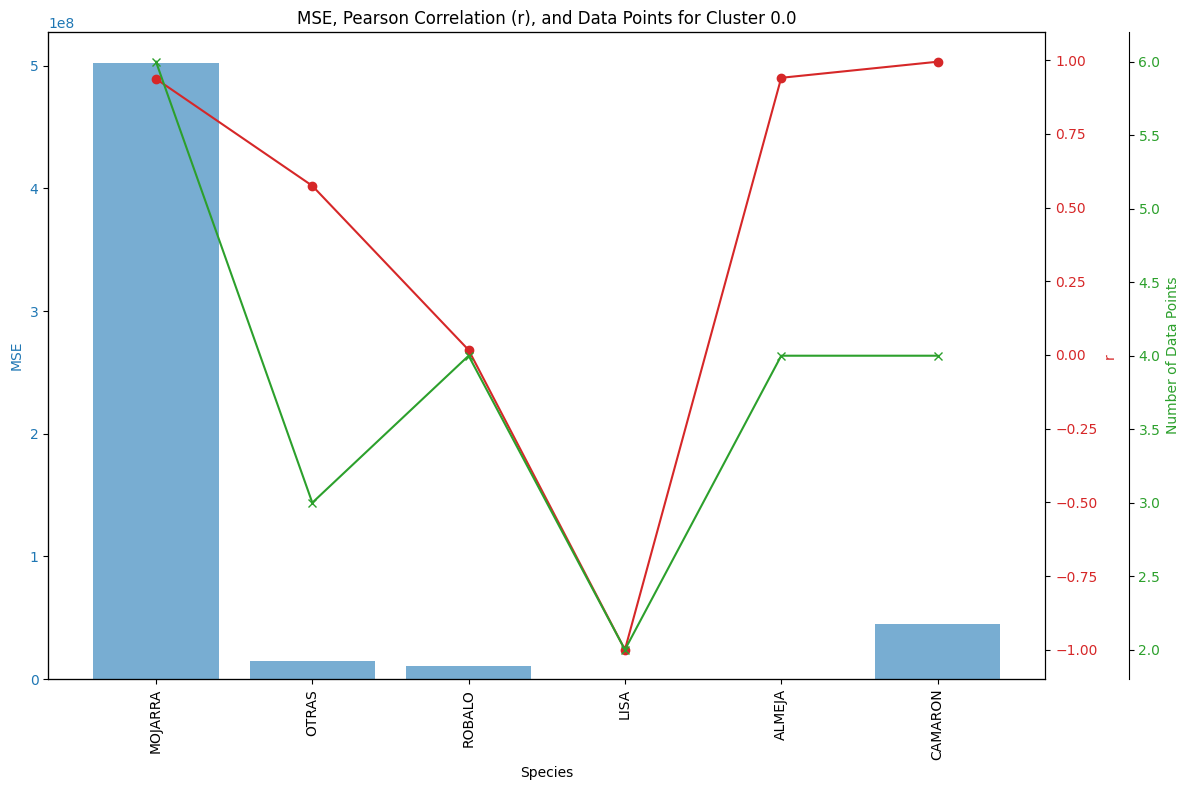

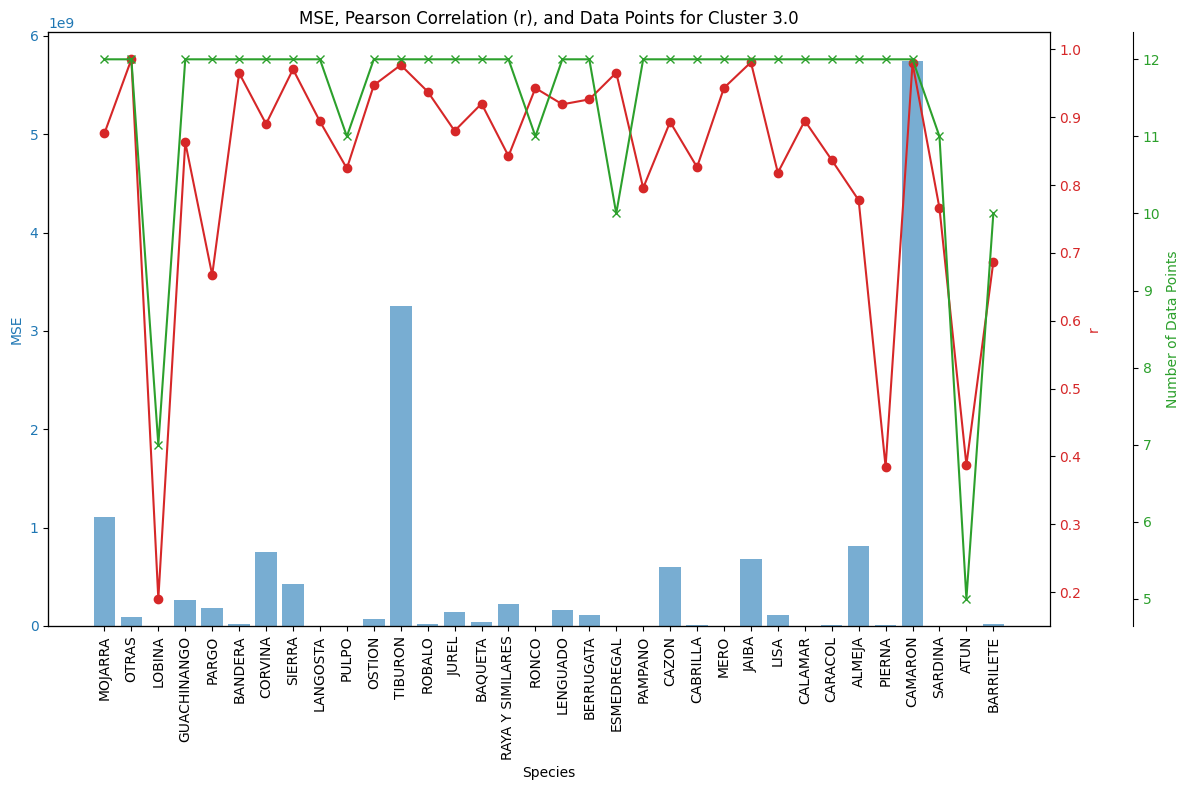

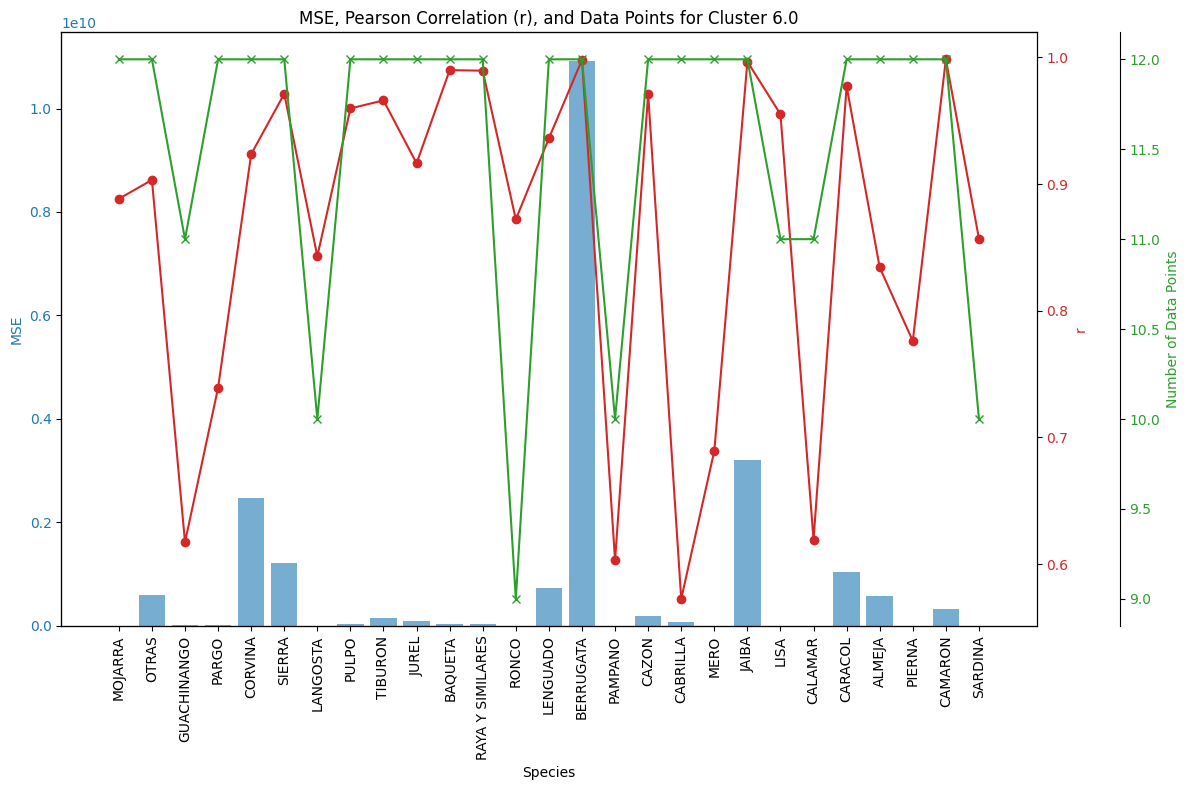

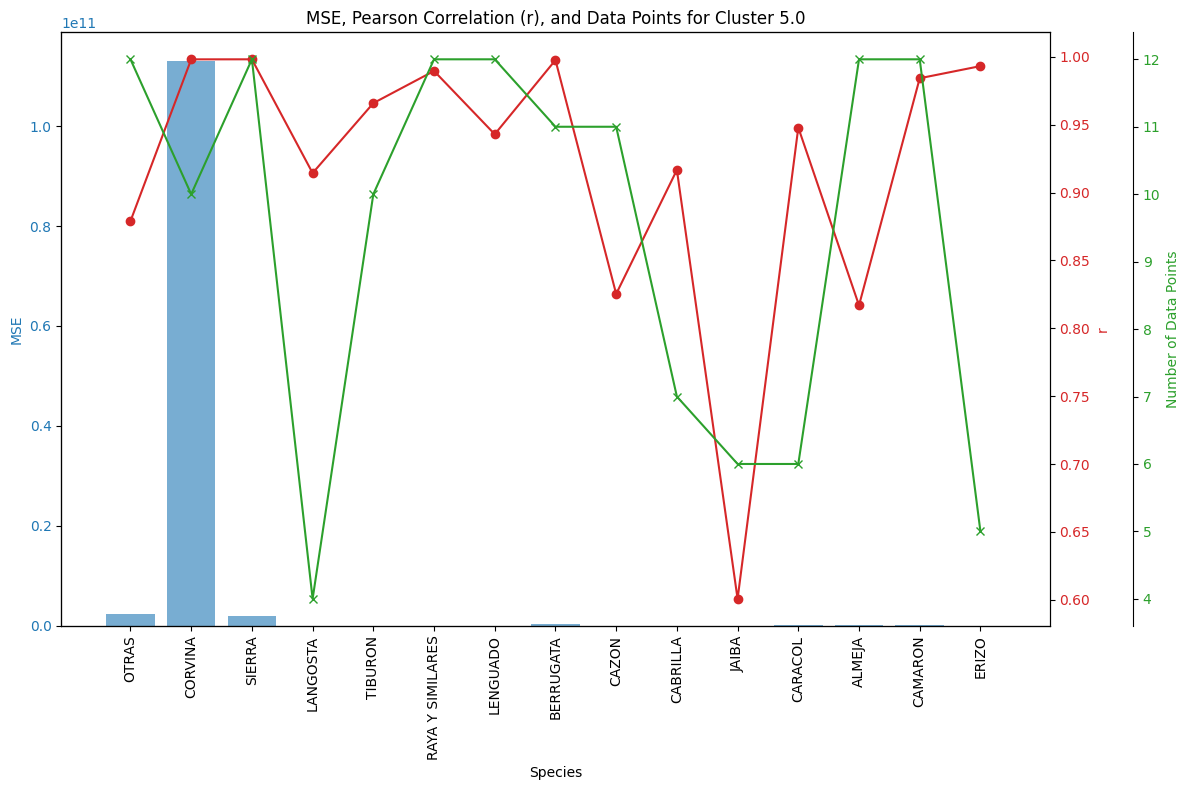

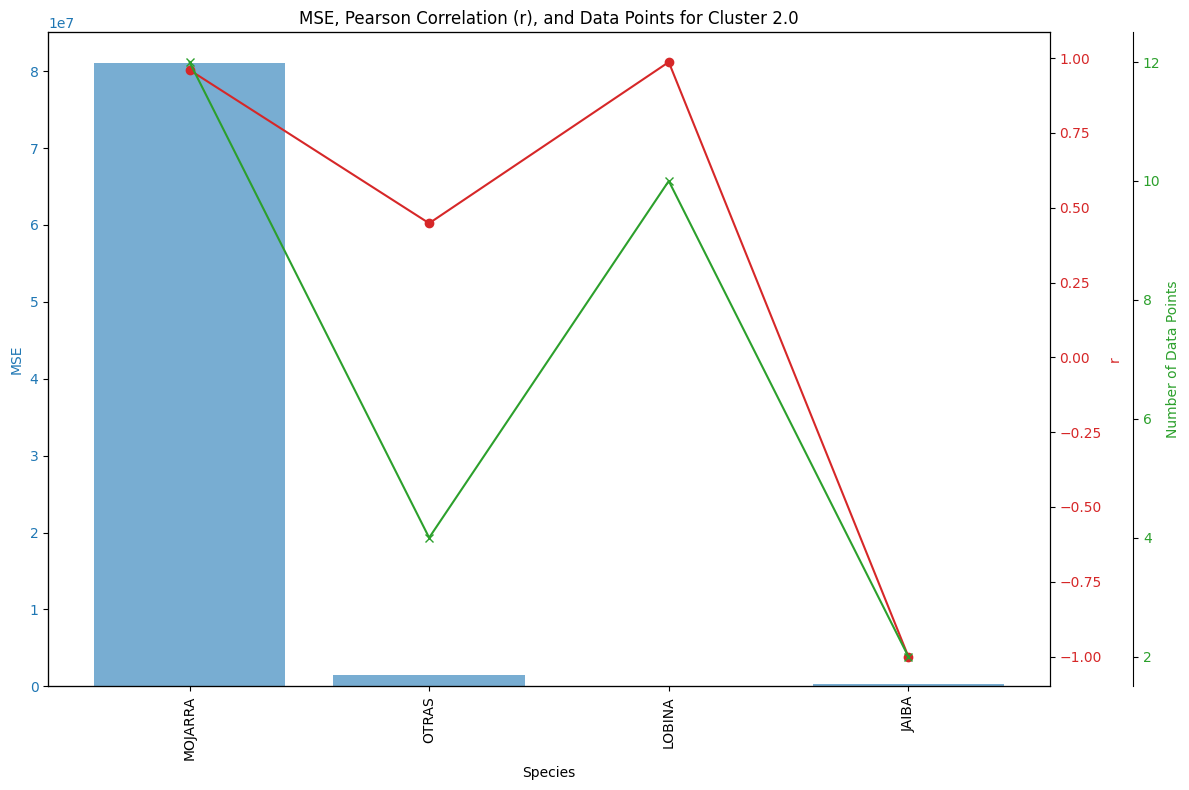

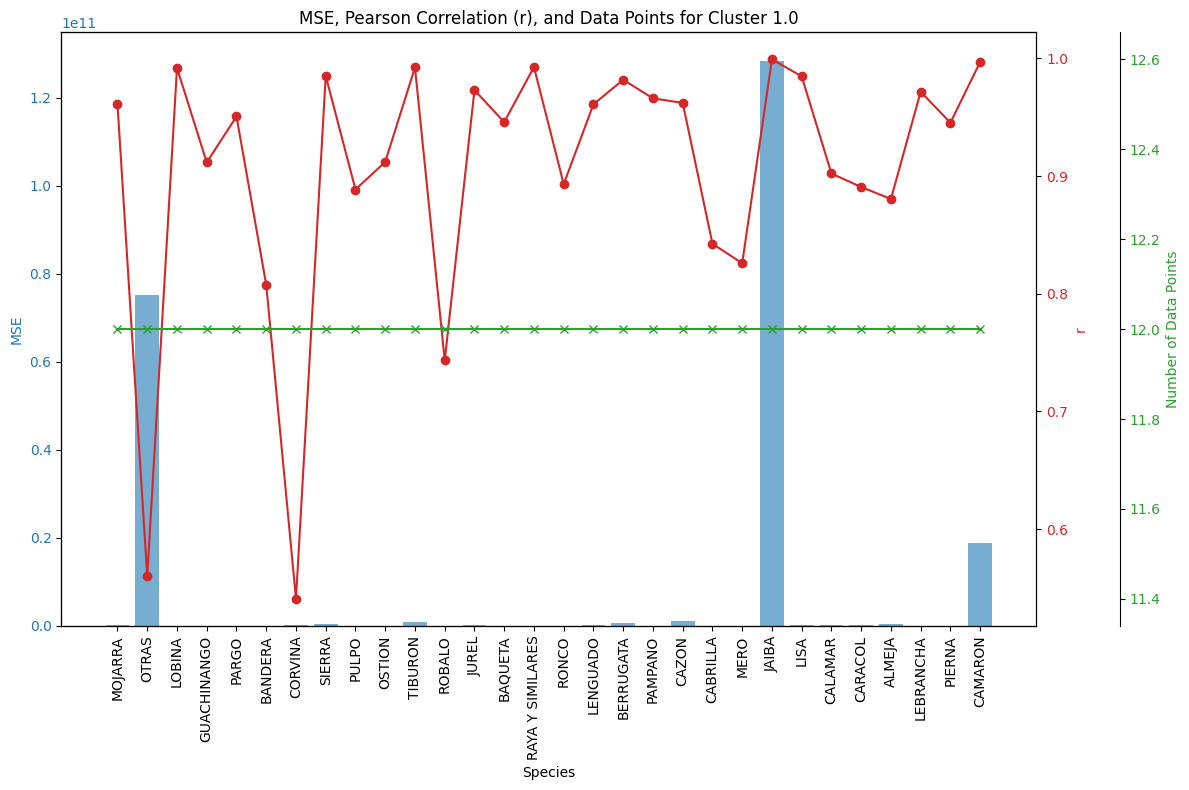

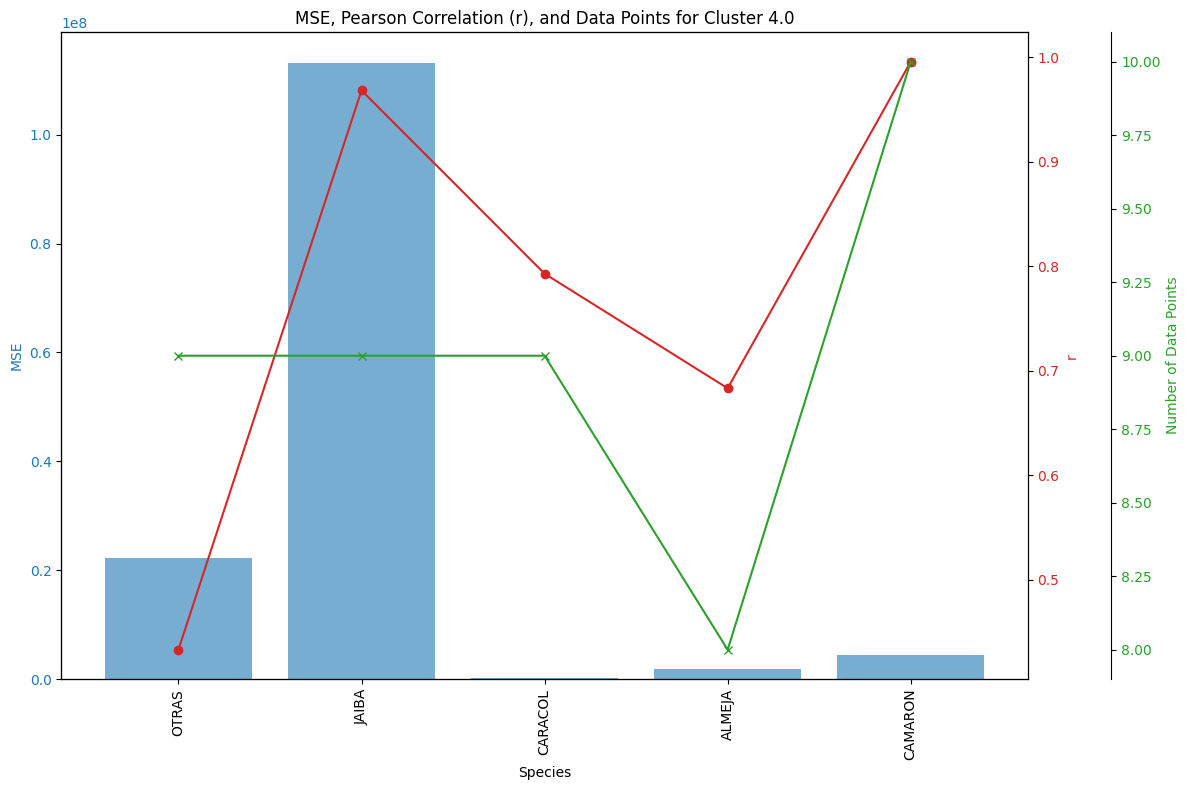

In [10]:
import os
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Iterar sobre cada clúster para calcular y graficar MSE, r y el número de datos disponibles
for cluster_label in unique_clusters:
    mse_values = []
    r_values = []
    num_data_points = []
    labels = []
    
    for species_name in unique_species:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular MSE y el coeficiente de correlación de Pearson (r)
            if len(monthly_totals) >= 2:
                mse = mean_squared_error(monthly_totals['real_values'], monthly_totals['predictions'])
                corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                
                # Almacenar los valores para graficar
                mse_values.append(mse)
                r_values.append(corr)
                num_data_points.append(len(monthly_totals))
                labels.append(species_name)
    
    # Crear la gráfica para el clúster actual
    if mse_values and r_values:
        fig, ax1 = plt.subplots(figsize=(12, 8))

        # Graficar MSE
        color = 'tab:blue'
        ax1.set_xlabel('Species')
        ax1.set_ylabel('MSE', color=color)
        ax1.bar(labels, mse_values, color=color, alpha=0.6)
        ax1.tick_params(axis='y', labelcolor=color)
        plt.xticks(rotation=90)

        # Crear un segundo eje para graficar r
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('r', color=color)
        ax2.plot(labels, r_values, color=color, marker='o')
        ax2.tick_params(axis='y', labelcolor=color)

        # Agregar un tercer eje para graficar el número de datos disponibles
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))  # Mover el tercer eje a la derecha
        color = 'tab:green'
        ax3.set_ylabel('Number of Data Points', color=color)
        ax3.plot(labels, num_data_points, color=color, marker='x')
        ax3.tick_params(axis='y', labelcolor=color)

        # Título y leyendas
        plt.title(f'MSE, Pearson Correlation (r), and Data Points for Cluster {cluster_label}')
        fig.tight_layout()
        plt.show()

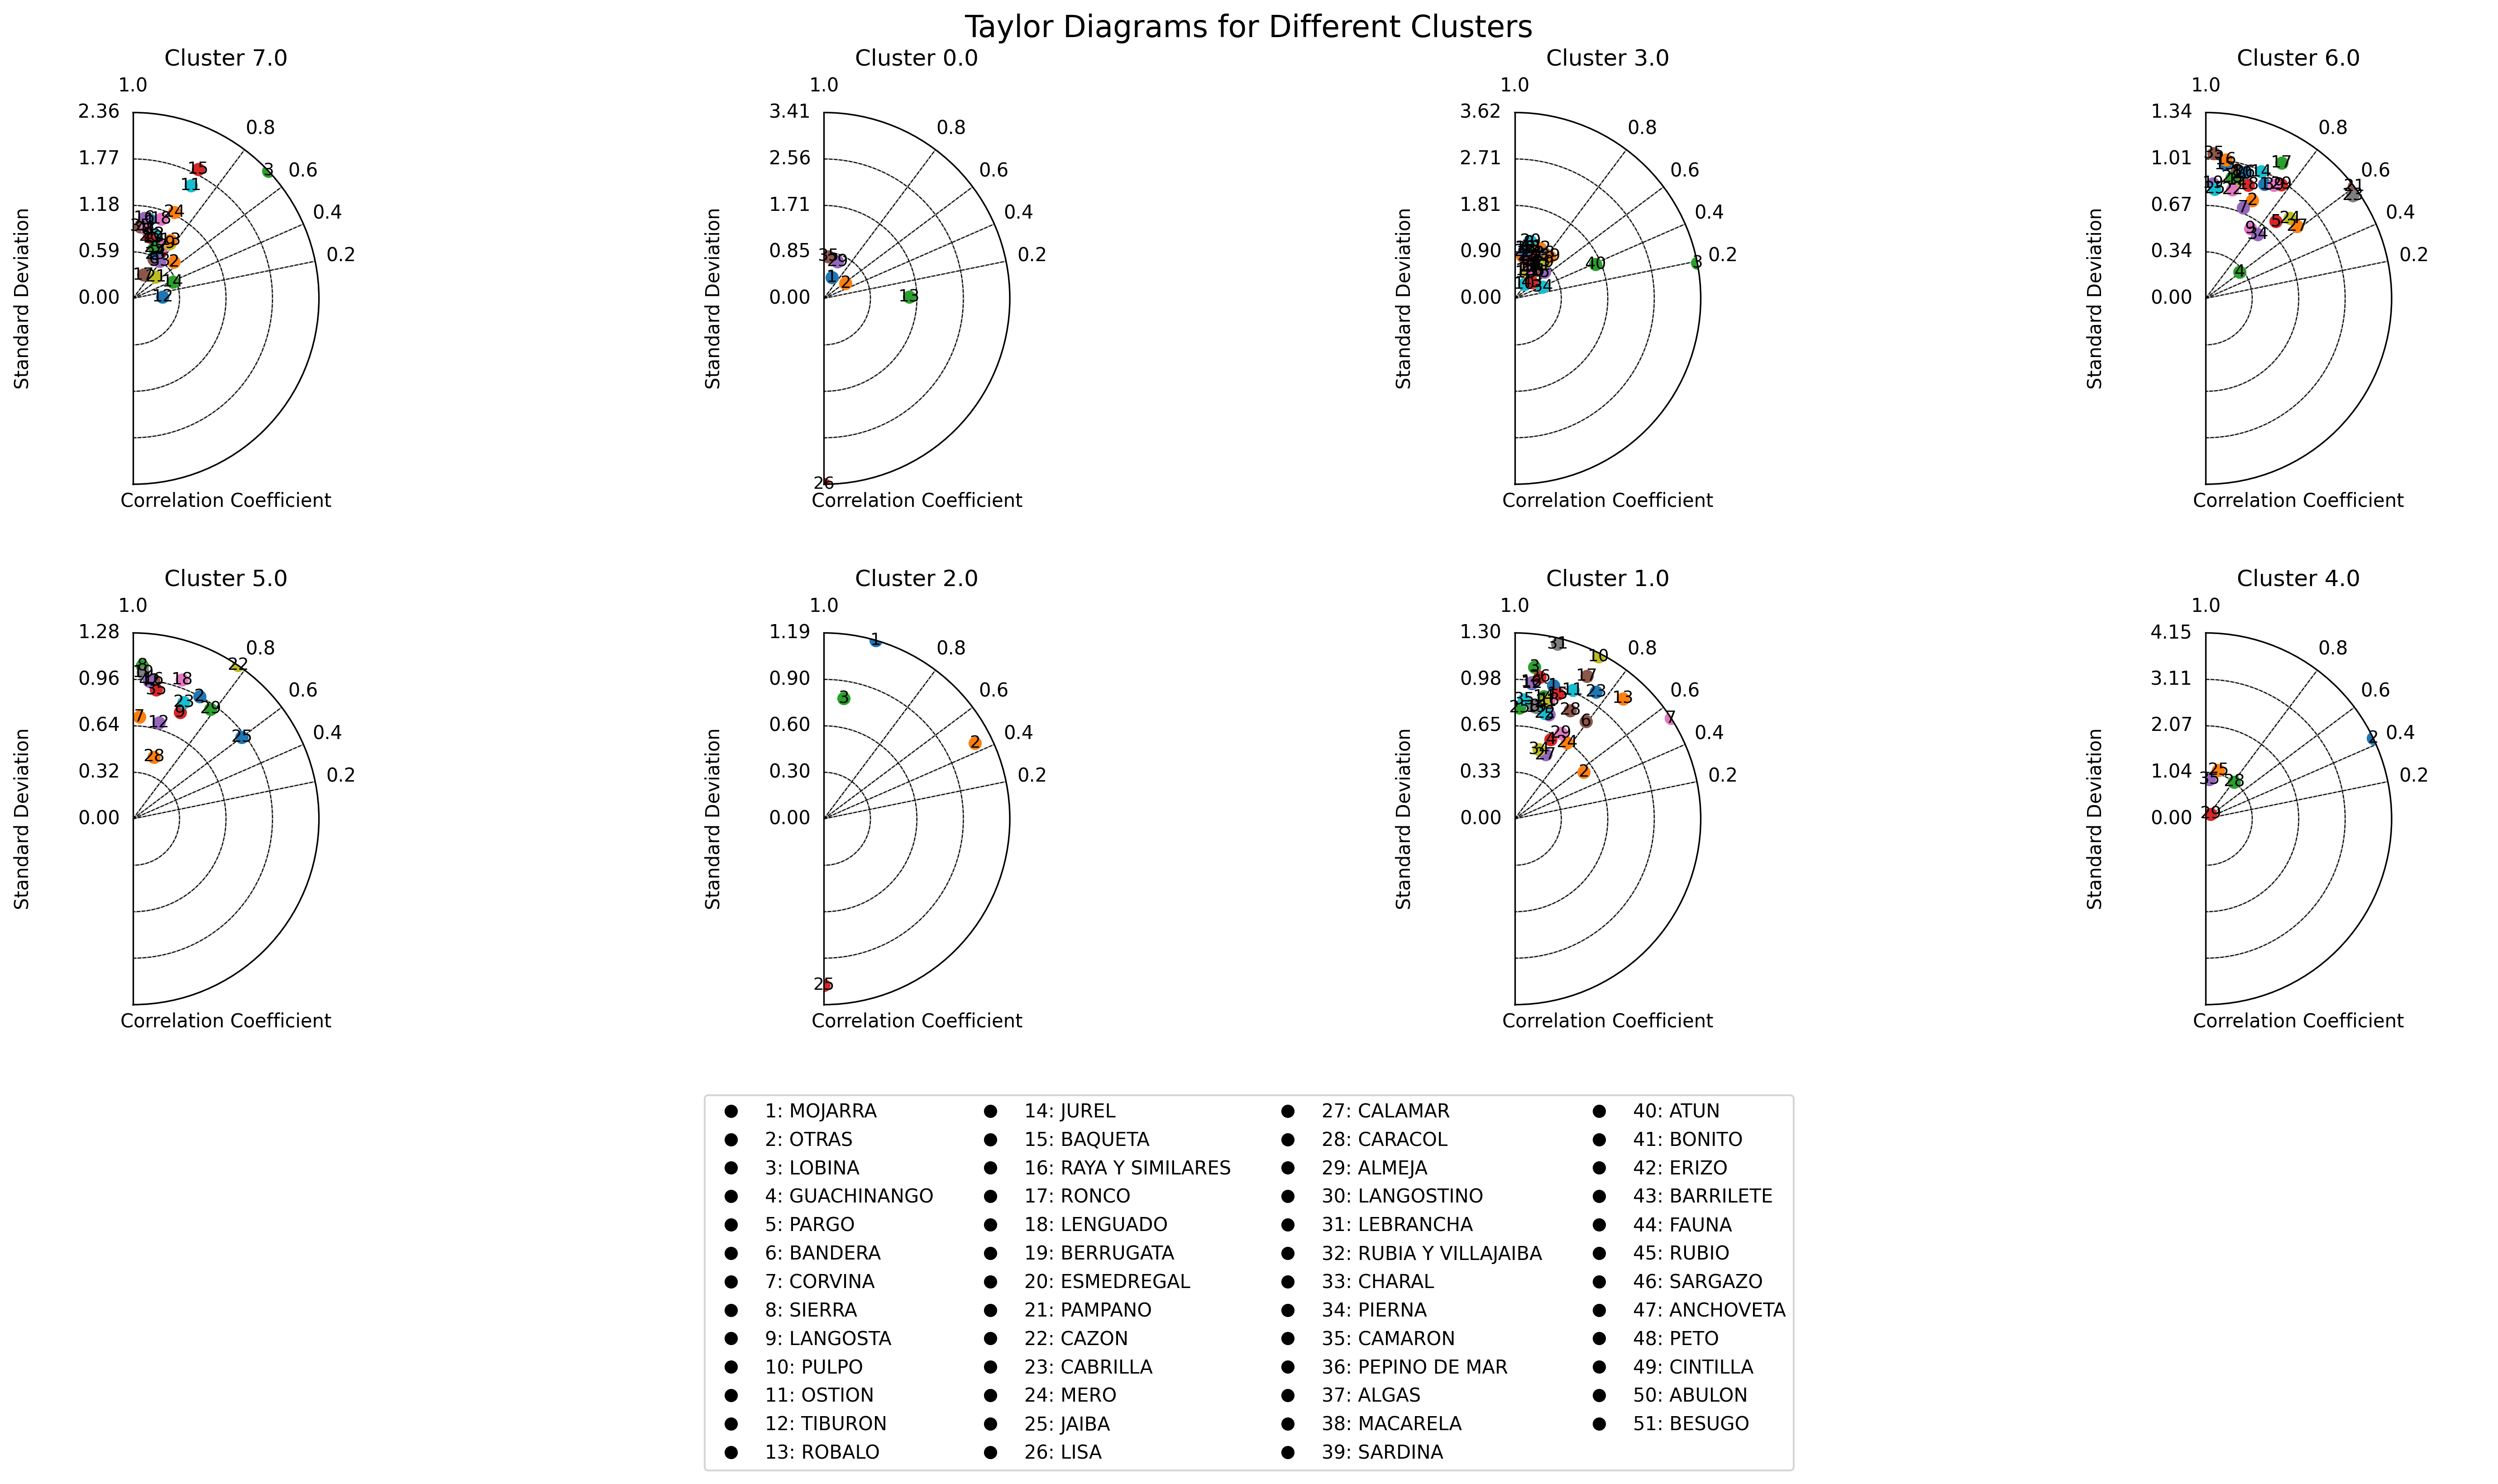

In [37]:
import os
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Función para crear el diagrama de Taylor
def taylor_diagram(ax, stddev, corrcoef, species_numbers, title):
    # Conversión del coeficiente de correlación a ángulos
    theta = np.arccos(corrcoef)
    
    # Dibujar círculos de referencia para la desviación estándar
    for std in np.linspace(0, max(stddev), 5):
        ax.plot(np.linspace(0, np.pi, 100), np.full(100, std), 'k--', lw=0.5)

    # Dibujar líneas de referencia para el coeficiente de correlación
    for r in [0.2, 0.4, 0.6, 0.8, 1.0]:
        ax.plot([np.arccos(r)]*100, np.linspace(0, max(stddev), 100), 'k--', lw=0.5)

    # Añadir puntos para cada modelo
    for i, (std, t) in enumerate(zip(stddev, theta)):
        ax.plot(t, std, 'o', label=f'Species {species_numbers[i]}')
        ax.text(t, std, str(species_numbers[i]), fontsize=9, ha='center', va='center')

    # Configurar el eje
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    ax.set_rlim(0, max(stddev))
    ax.set_yticks(np.linspace(0, max(stddev), 5))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(0, max(stddev), 5)])
    ax.set_xticks(np.arccos([0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])

    ax.set_title(title)
    ax.grid(True)

    # Añadir títulos a los ejes
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Standard Deviation')

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Crear la figura para todos los subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw={'polar': True}, dpi=300)
axes = axes.flatten()

# Mapeo de especies a números
species_to_num = {species: num for num, species in enumerate(unique_species, 1)}

# Iterar sobre cada clúster para crear el diagrama de Taylor
for ax, cluster_label in zip(axes, unique_clusters):
    stddev = []
    corrcoef = []
    species_numbers = []
    
    for species_name in unique_species:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular las métricas
            if len(monthly_totals) >= 2:
                std_obs = np.std(monthly_totals['real_values'])
                std_pred = np.std(monthly_totals['predictions'])
                corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                
                # Almacenar los valores para el diagrama de Taylor
                stddev.append(std_pred / std_obs)
                corrcoef.append(corr)
                species_numbers.append(species_to_num[species_name])
    
    # Crear el diagrama de Taylor para el clúster actual
    if stddev and corrcoef:
        taylor_diagram(ax, stddev, corrcoef, species_numbers, title=f'Cluster {cluster_label}')

# Crear una única leyenda con nombres de especies y sus números
species_labels = [f'{num}: {species}' for species, num in species_to_num.items()]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label=label) for label in species_labels]
fig.legend(handles=handles, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

# Añadir títulos y etiquetas a los ejes
fig.suptitle('Taylor Diagrams for Different Clusters', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2, bottom=0.25)
plt.show()


/var/tmp/ipykernel_15093/4022120256.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  count_df = count_df.fillna(0).apply(pd.to_numeric, errors='coerce')


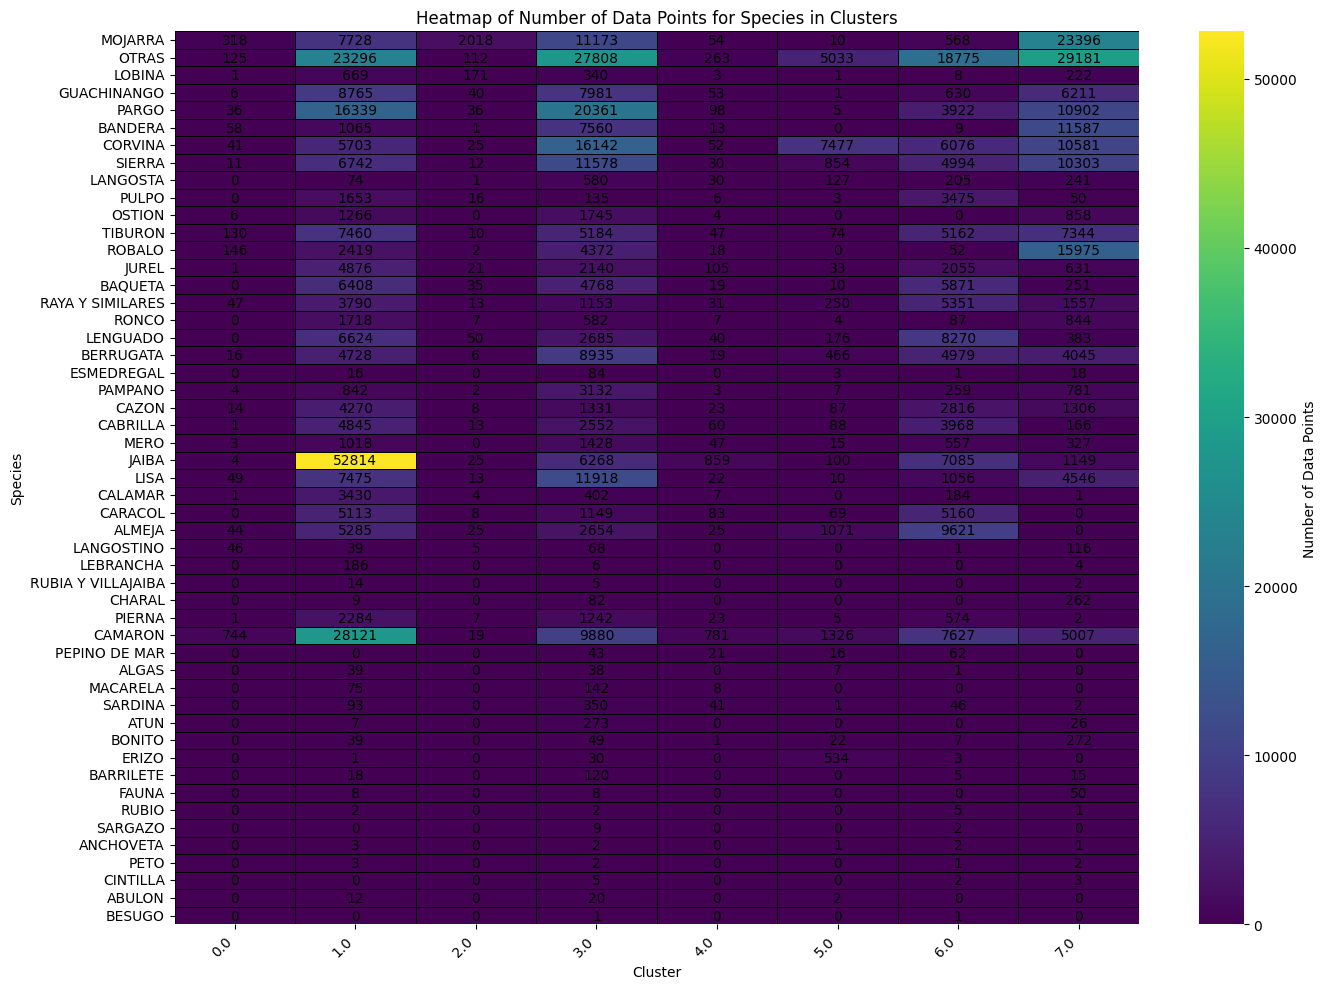

In [17]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que 'data' es el DataFrame original con los datos de entrenamiento
# data debería contener las columnas 'species', 'Cluster_Label', 'date'

# Asegúrate de que la columna 'date' sea de tipo datetime
data['date'] = pd.to_datetime(data['date'])

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar un DataFrame para almacenar el número de datos disponibles
count_df = pd.DataFrame(index=unique_species, columns=unique_clusters)

# Iterar sobre cada combinación de especie y clúster para contar el número de datos disponibles
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Filtrar los datos para la especie y el clúster específicos
        filtered_data = data[(data['species'] == species_name) & (data['Cluster_Label'] == cluster_label)]
        
        # Contar el número de datos disponibles
        count_df.at[species_name, cluster_label] = len(filtered_data)

# Reemplazar valores None o NaN con 0
count_df = count_df.fillna(0).apply(pd.to_numeric, errors='coerce')

# Contar los valores no nulos por fila y ordenar las especies
count_df['non_null_count'] = count_df.notnull().sum(axis=1)
count_df = count_df.sort_values(by='non_null_count', ascending=False).drop(columns=['non_null_count'])

# Definir el orden deseado de las columnas
column_order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']

# Reindexar el DataFrame según el orden de las columnas
count_df.columns = count_df.columns.astype(str)
count_df = count_df.reindex(columns=column_order)
count_df.index = count_df.index.astype(str)

# Crear una máscara para los valores fuera del rango
mask = count_df.isna()

# Crear el mapa de calor
plt.figure(figsize=(14, 10))  # Aumentar el tamaño de la figura
heatmap = sns.heatmap(count_df, annot=True, fmt='d', cmap='viridis', cbar_kws={'label': 'Number of Data Points'}, linewidths=.5, linecolor='black', mask=mask, annot_kws={"color": "black"})

# Ajustar los ticks de los ejes para mayor claridad
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas de las columnas
plt.yticks(rotation=0)  # Asegurar que las etiquetas de los renglones estén rectas

# Añadir títulos y etiquetas
plt.title('Heatmap of Number of Data Points for Species in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Species')

# Mostrar el mapa de calor
plt.tight_layout()
plt.show()
